In [2]:
import numpy as np
import sys, os, pickle, h5py, time

from iminuit import Minuit
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from astropy import coordinates as coord

# Load the Data

In this notebook, we perform the analysis over the data in the range 0-30 keV binned at 1 keV resolution obtained from Fig. 4 of 2006.09721. The observational data and model spectra are loaded from the archive `Data_30keV.h5`

In [3]:
data_archive = h5py.File('../Data/Data_30keV.h5', 'r')

emins, emaxs = np.array(data_archive['BinEdges'])
flux_obs = np.array(data_archive['Flux'])
flux_err = np.array(data_archive['FluxError'])

ens_bkg, flux_bkg = np.array(data_archive['Background'])
ens_ABC, flux_ABC = np.array(data_archive['ABC_Model'])

data_archive.close()

ens_flux = (emins + emaxs)/2
binsize = emaxs - emins

# Utility Methods

Two utility methods are provided. First, `rebin` rebins a `spectrum` specified at energies `e` to the 1 keV binning resolution of the binned flux data for use in a binned analysis. The `rebin` method is also used to add an arbitrary shift `E_Shift` to the energies at which the spectrum is specified


The second utiity method is `ChiSq`, which calculates the improvement to the $\chi^2$ statistic based on the inclusion of a ABC axion signal template with an energy shift `E_Shift`. The background model is unshifted in this analysis. `ChiSq` accepts the observed flux data as `data` and errors as `errors` in order to facilitate Monte Carlo tests. `ChiSq` also returns the best fit amplitude, which is allowed to take positive or negative values, for the shifted ABC spectrum.

In [7]:
def rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    interp_spectrum = np.interp(interp_energies, e, spectrum)
    
    interp_energies += E_Shift
    
    binned_spectrum = np.zeros_like(emins)
    for i in range(len(binned_spectrum)):
        
        min_index = np.searchsorted(interp_energies, emins[i])
        max_index = np.searchsorted(interp_energies, emaxs[i])
        
        binned_spectrum[i] = np.trapz(interp_spectrum[min_index:max_index], interp_energies[min_index:max_index])
    return np.nan_to_num(binned_spectrum) / binsize

def ChiSq(data, errors, bkg_spectrum, E_Shift):
    
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    Return the best fit signal amplitude and the change in chi^2 statistic.
    '''
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum[np.where(emins < 1 + E_Shift)] = 0
    
    obj = lambda A: np.sum((data - A*abc_spectrum - bkg_spectrum)**2 / errors**2)
    NullChiSq = obj(0)

    m = Minuit(obj, A = 0, limit_A = [None, None], error_A = .1,errordef = 1)
    m.migrad()
    
    fit = m.values['A']
    SignalChiSq = m.fval

    return fit, NullChiSq-SignalChiSq
    
    

# Analysis

In [6]:
# Make the rebinned background spectrum
bkg_spectrum = rebin(ens_bkg, flux_bkg)
bkg_spectrum[-1] = bkg_spectrum[-2] # Manually correct the last data point

## Real Data Analysis 

First, we calculate the improvement to the $\chi^2$ statistic as a function of the energy by which the ABC spectrum is shifted in 125 eV steps in energy shift between 0 and 23 keV. Using the best fit amplitudes, we construct the best fit signal+background for the excess observed at an energy shift of 0 keV, which corresponds to the claimed detection in 2006.09721, and for the location corresponding to the highest significance fit over the 0-23 keV range of shift energies.

In [9]:
E_Shifts = np.linspace(0, 23, 23*8+1)
Fit_Results = np.zeros((len(E_Shifts), 2))

for i in range(len(E_Shifts)):
    Fit_Results[i] = ChiSq(flux_obs, flux_err,bkg_spectrum ,E_Shifts[i])
    
    
    
best_fit_index = np.argmax(Fit_Results[:, 1])
best_fit_template = Fit_Results[best_fit_index, 0] * rebin(ens_ABC, flux_ABC, E_Shift = E_Shifts[best_fit_index])+bkg_spectrum#bkg_spectrum
best_fit_US = Fit_Results[0, 0] * rebin(ens_ABC, flux_ABC, E_Shift = 0.0)+bkg_spectrum#bkg_spectrum

## Monte Carlo Tests
After fitting the data, we evaluate the robustness of the analysis by constructing Monte Carlo data of background + signal at energy shift 0 keV. That the $\Delta \chi^2$ evaluated on Monte Carlo data follows a $\chi^2$ distribution at shift energies $\gsim$ 7 keV shows that our analysis is unbiased by the possible presence of a genuine axion signal at low energies. 

In [6]:
mc_template = Fit_Results[0, 0] * rebin(ens_ABC, flux_ABC, E_Shift = 0)
mc_template += bkg_spectrum

Nmc = 5000
mc_data = stats.norm.rvs(loc = mc_template, scale = flux_err, size = (Nmc, len(mc_template)))


MC_Fit_Results = np.zeros((mc_data.shape[0], len(E_Shifts), 2))

for i in range(MC_Fit_Results.shape[0]):
    for j in range(MC_Fit_Results.shape[1]):
        MC_Fit_Results[i, j] = ChiSq(mc_data[i], flux_err , bkg_spectrum, E_Shifts[j])
    print(i)
clear_output()

## Results

Here we plot the results we obtain from the real data and Monte Carlo analyses to produce Fig. 1 presented in our work. The presence of a high significance fit to data around 15 keV at the site of a large underfluctuation indicates the possibility of systematic mismodelling at these low energies.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


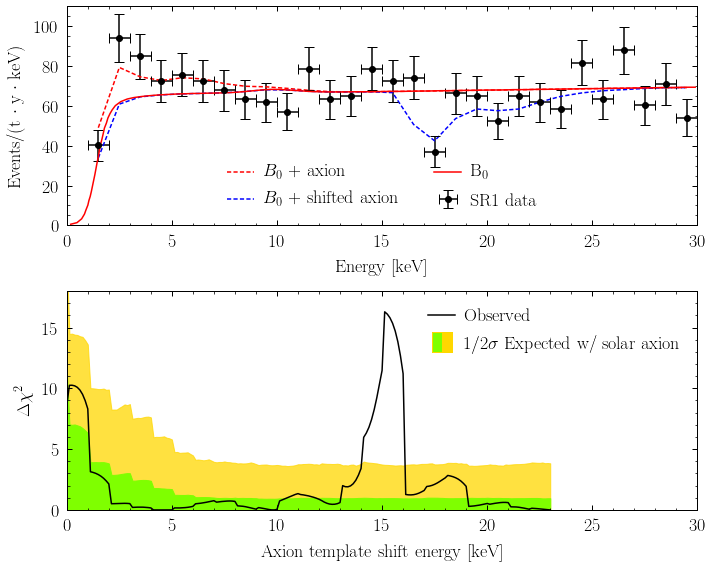

In [9]:
fig, axs = plt.subplots(nrows = 2,figsize=(10,8))

fontsize=18

axs[0].plot(ens_flux, best_fit_US, c='red', ls = '--', label = r'$B_0$ + axion')
axs[0].plot(ens_flux, best_fit_template, c='blue', ls = '--', label = r'$B_0$ + shifted axion')
axs[0].errorbar(ens_flux,flux_obs,xerr=binsize/2.,yerr=flux_err,fmt='o',color='k',capsize=5,label='SR1 data')
axs[0].plot(ens_bkg,flux_bkg,color='r',label='B$_0$')
axs[0].set_xlabel('Energy [keV]',fontsize=fontsize)
axs[0].set_ylabel(r'Events/(t $\cdot$ y $\cdot$ keV)',fontsize=fontsize)
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,110)
axs[0].legend(loc='lower center',frameon=False, fontsize =fontsize,ncol=2)




axs[1].plot(E_Shifts, Fit_Results[:, 1], c = 'black', zorder = 11, label = 'Unmasked')
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 1], 0.0, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 1], .95, axis = 0), color = 'gold', alpha = .75)
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 1], 0.0, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 1], .68, axis = 0), color = 'chartreuse', alpha = 1.)


axs[1].set_ylim(0, 18)
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs[1].set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)
axs[1].legend()



msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = axs[1].get_legend_handles_labels()
handles1 = [handles[0], (m3 ,m4)]
labels1 = [r'Observed', r'$1/2\sigma$ Expected w/ solar axion']

axbox = axs[1].get_position()
x_value= -0.1
y_value= .65

legend1 = axs[1].legend(handles1,labels1, frameon=False, fontsize = fontsize)

axs[0].tick_params(axis='x', labelsize= fontsize)
axs[0].tick_params(axis='y', labelsize= fontsize)
axs[1].tick_params(axis='x', labelsize= fontsize)
axs[1].tick_params(axis='y', labelsize= fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace = .3)
plt.savefig('../Plots/Fig1.pdf')
plt.savefig('../Plots/Fig1.png')
plt.show()